In [1]:
%load_ext google.cloud.bigquery

In [2]:
!pip install google-cloud-bigquery-storage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 2.1 MB/s eta 0:00:00a 0:00:01


In [3]:
!pip install pyarrow

In [5]:
%%bigquery
SELECT * 
FROM certain-arcana-418302.KK_data.tuser_logs_v3
LIMIT 3

Query complete after 0.00s: 100% 2/2 [00:00<00:00, 716.18query/s]                         
Downloading: 100% 3/3 [00:00<00:00,  3.18rows/s]


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,OtQ15zNJRj0TP/QxhaI8U+NVPtPP9csPobTrrplxFSU=,20161016,0,0,1,0,0,1,112.058
1,hfncPT8QSjNDmDyTD7E0UCcn5c5C3vZrNEKaZwDxDVw=,20160803,0,0,1,0,0,1,148.933
2,/11gwhivP3GqbDk4g+hD5OZtCQAqNK96A+OfLkPfBvI=,20160802,0,0,1,0,0,1,110.237


### 訓練集

In [6]:
from google.cloud import bigquery
import pandas as pd

# 创建 BigQuery 客户端
client = bigquery.Client()

# 执行 SQL 查询
query = """
-- user_latent_satisfaction CTE
WITH feature AS(
                SELECT msno, AVG(single_day_latent_satisfaction) AS user_latent_satisfaction
                FROM( 
                     SELECT msno, ( num_100 / (num_25 + num_50 + num_75 + num_985 + num_100) ) AS single_day_latent_satisfaction
                     FROM certain-arcana-418302.KK_data.tuser_logs_v3
                     WHERE date > 20160901 AND date < 20170228 )
                GROUP BY msno)
SELECT train.msno, feature.user_latent_satisfaction
FROM certain-arcana-418302.KK_data.tuser_label_201703 AS train
LEFT JOIN feature
ON  train.msno = feature.msno
"""
query_job = client.query(query)

# 将结果读取到 Pandas DataFrame 中
df = query_job.to_dataframe()

# 打印结果
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886500 entries, 0 to 886499
Data columns (total 2 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   msno                      886500 non-null  object 
 1   user_latent_satisfaction  732868 non-null  float64
dtypes: float64(1), object(1)
memory usage: 13.5+ MB


In [12]:
df.head(3)

,msno,user_latent_satisfaction
0,5+Q3O5hB7RwWFiAjzHk7jXkmEL+f+FEgWA14b/+pLdY=,0.608657
1,reMxMvntTlO/P0YiL8SUt9O66FGBpcEAuKlItmc8Org=,0.374266
2,eItYfr9RtQtJWgoQq6ubKXEN7FNQHzcchmYyEo0bEg8=,0.690110


In [7]:
# 执行 SQL 查询
query = """
-- day_listen CTE
WITH features AS (
                   SELECT msno AS msno , COUNT(msno) AS day_listen
                   FROM certain-arcana-418302.KK_data.tuser_logs_v3 AS train
                   WHERE date > 20160901 AND date < 20170228 
                   GROUP BY msno)
SELECT train.msno, train.is_churn, features.day_listen
FROM certain-arcana-418302.KK_data.tuser_label_201703 AS train
LEFT JOIN features 
ON   train.msno = features.msno
"""
query_job = client.query(query)

# 将结果读取到 Pandas DataFrame 中
df1 = query_job.to_dataframe()

# 打印结果 
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886500 entries, 0 to 886499
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   msno        886500 non-null  object 
 1   is_churn    886500 non-null  object 
 2   day_listen  732868 non-null  float64
dtypes: float64(1), object(2)
memory usage: 20.3+ MB


In [8]:
df_train = pd.merge(df1, df, how='left',on=['msno'])

### 測試集

In [9]:
# 执行 SQL 查询
query = """
-- user_latent_satisfaction CTE
WITH feature AS(
                SELECT msno, AVG(single_day_latent_satisfaction) AS user_latent_satisfaction
                FROM( 
                     SELECT msno, ( num_100 / (num_25 + num_50 + num_75 + num_985 + num_100) ) AS single_day_latent_satisfaction
                     FROM certain-arcana-418302.KK_data.tuser_logs_v3
                     WHERE date > 20161001 AND date < 20170331)
                GROUP BY msno)
SELECT sub.msno, feature.user_latent_satisfaction
FROM certain-arcana-418302.KK_data.tsample_submission_v2 AS sub
LEFT JOIN feature
ON  sub.msno = feature.msno
"""
query_job = client.query(query)

# 将结果读取到 Pandas DataFrame 中
dft = query_job.to_dataframe()

# 打印结果
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907471 entries, 0 to 907470
Data columns (total 2 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   msno                      907471 non-null  object 
 1   user_latent_satisfaction  749999 non-null  float64
dtypes: float64(1), object(1)
memory usage: 13.8+ MB


In [16]:
dft.head(3)

,msno,user_latent_satisfaction
0,oUntgm+flqrl8fcotrywFIiGLHQkSlmG1xIOwlZ/qqM=,0.608227
1,lE67sJnCkyrti2/NZ6Z+oKwLQo8m40PyuIlJJkTYUrc=,0.413166
2,6zgxuwhsoGaEj5kWYo60N5vpJ6QghKzEZCigRjyv9hs=,0.819798


In [10]:
# 执行 SQL 查询
query = """
-- day_listen CTE
WITH features AS (
                   SELECT msno AS msno , COUNT(msno) AS day_listen
                   FROM certain-arcana-418302.KK_data.tuser_logs_v3
                   -- Filter 20160201 , 20170228
                   WHERE date > 20161001 AND date < 20170331 
                   GROUP BY msno)
SELECT sub.msno, sub.is_churn, features.day_listen
FROM certain-arcana-418302.KK_data.tsample_submission_v2 AS sub
LEFT JOIN features 
ON   sub.msno = features.msno
"""
query_job = client.query(query)

# 将结果读取到 Pandas DataFrame 中
dft1 = query_job.to_dataframe()

# 打印结果
dft1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907471 entries, 0 to 907470
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   msno        907471 non-null  object 
 1   is_churn    907471 non-null  int64  
 2   day_listen  749999 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.8+ MB


In [11]:
df_sub = pd.merge(dft1, dft, how='left',on=['msno'])
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907471 entries, 0 to 907470
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   msno                      907471 non-null  object 
 1   is_churn                  907471 non-null  int64  
 2   day_listen                749999 non-null  float64
 3   user_latent_satisfaction  749999 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 27.7+ MB


### 探索性分析(Exploratory Data Analysis)

In [13]:
# python packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df_train['is_churn'] = df_train['is_churn'].map({'true': 1, 'false': 0})

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mod

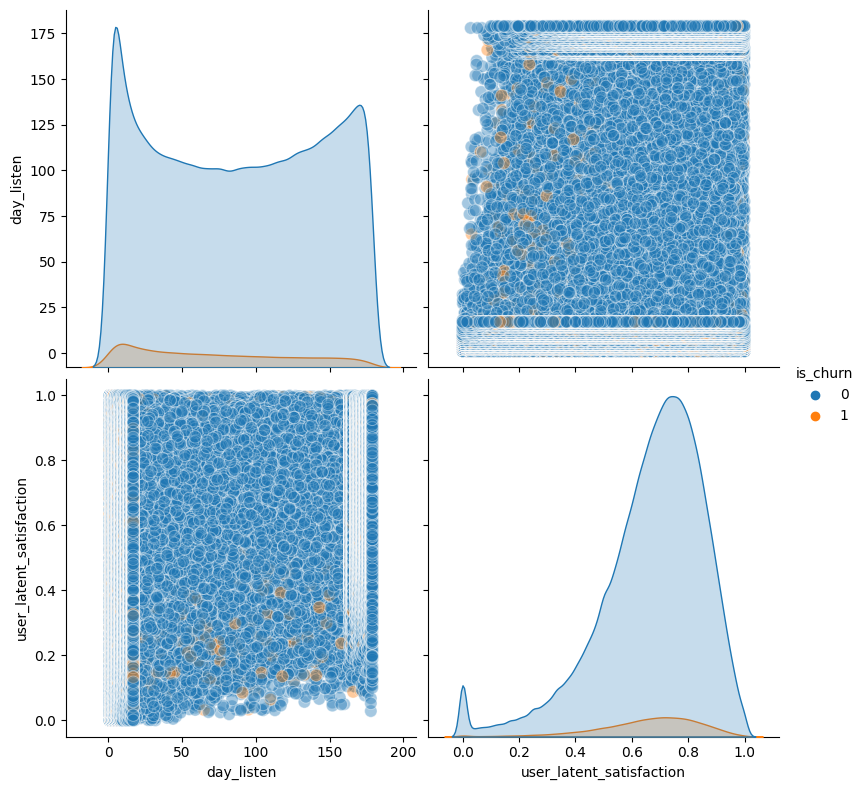

In [26]:
sns.pairplot(df_train.dropna(),vars=['day_listen','user_latent_satisfaction'],\
             diag_kind='kde',hue='is_churn',plot_kws = {'alpha': 0.4, 's': 80},size = 4)

In [8]:
# heat map
corr_matrix = df_train[['day_listen','user_latent_satisfaction','is_churn']].corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
  fig, ax = plt.subplots(figsize=(8,6))
  corr_map = sns.heatmap(corr_matrix,mask=mask,annot=True,ax=ax)
  plt.xticks(rotation=-15)

NameError: name 'np' is not defined

兩個特徵和是否流失的相關係數很低，這是因為noise很大，我們可以將特徵切分為聽歌天數等級(例如六個月內，聽得很少，聽得多，聽得很多)，來降低noise並進一步萃取特徵

### 缺失值(Missing Values)

In [14]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print('training set:')
print(''*60)
print(df_train.isnull().sum() / len(df_train))
print('_'*60)
print('testing set:')
print(''*60)
print(df_sub.isnull().sum() / len(df_sub))

training set:

msno                       0.000
is_churn                   1.000
day_listen                 0.173
user_latent_satisfaction   0.173
dtype: float64
____________________________________________________________
testing set:

msno                       0.000
is_churn                   0.000
day_listen                 0.174
user_latent_satisfaction   0.174
dtype: float64


### 填補策略

常見的方法有中位數，平均數，及眾數，利用其他特徵做統計推測，利用其他特徵做Regression等。

先全部填入 -1 ，當作一個特徵類別，在有些時候效果還算不錯。本篇文章中採取這個做法

In [15]:
# place nan in testing set
df_sub['is_churn'] = np.nan

# filling na with -1 on "'user_latent_satisfaction"
df_train['user_latent_satisfaction'] = df_train['user_latent_satisfaction'].fillna(-1)
df_sub['user_latent_satisfaction'] = df_sub['user_latent_satisfaction'].fillna(-1)

# combine
df_data = pd.concat([df_train, df_sub], axis=0)

### cut into bins day_listen->[-1, 1, 2, 3, 4]

In [16]:
# cut into bins
bins = 4
df_data.loc[(df_data.day_listen >= 0),'day_listen_level'] = pd.cut(df_data.loc[(df_data.day_listen >= 0),'day_listen'], bins,labels=[1,2,3,4])
# 將 day_listen_level 中的空值填為 -1
df_data['day_listen_level'] = df_data['day_listen_level'].cat.add_categories([-1])  # 添加新類別 -1
df_data['day_listen_level'] = df_data['day_listen_level'].fillna(-1)  # 將空值填為 -1

# prepare table (% of each value)
from pandas.plotting import table
df_percent = pd.DataFrame(df_data.day_listen_level.value_counts().sort_index() / len(df_data) ).round(3)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


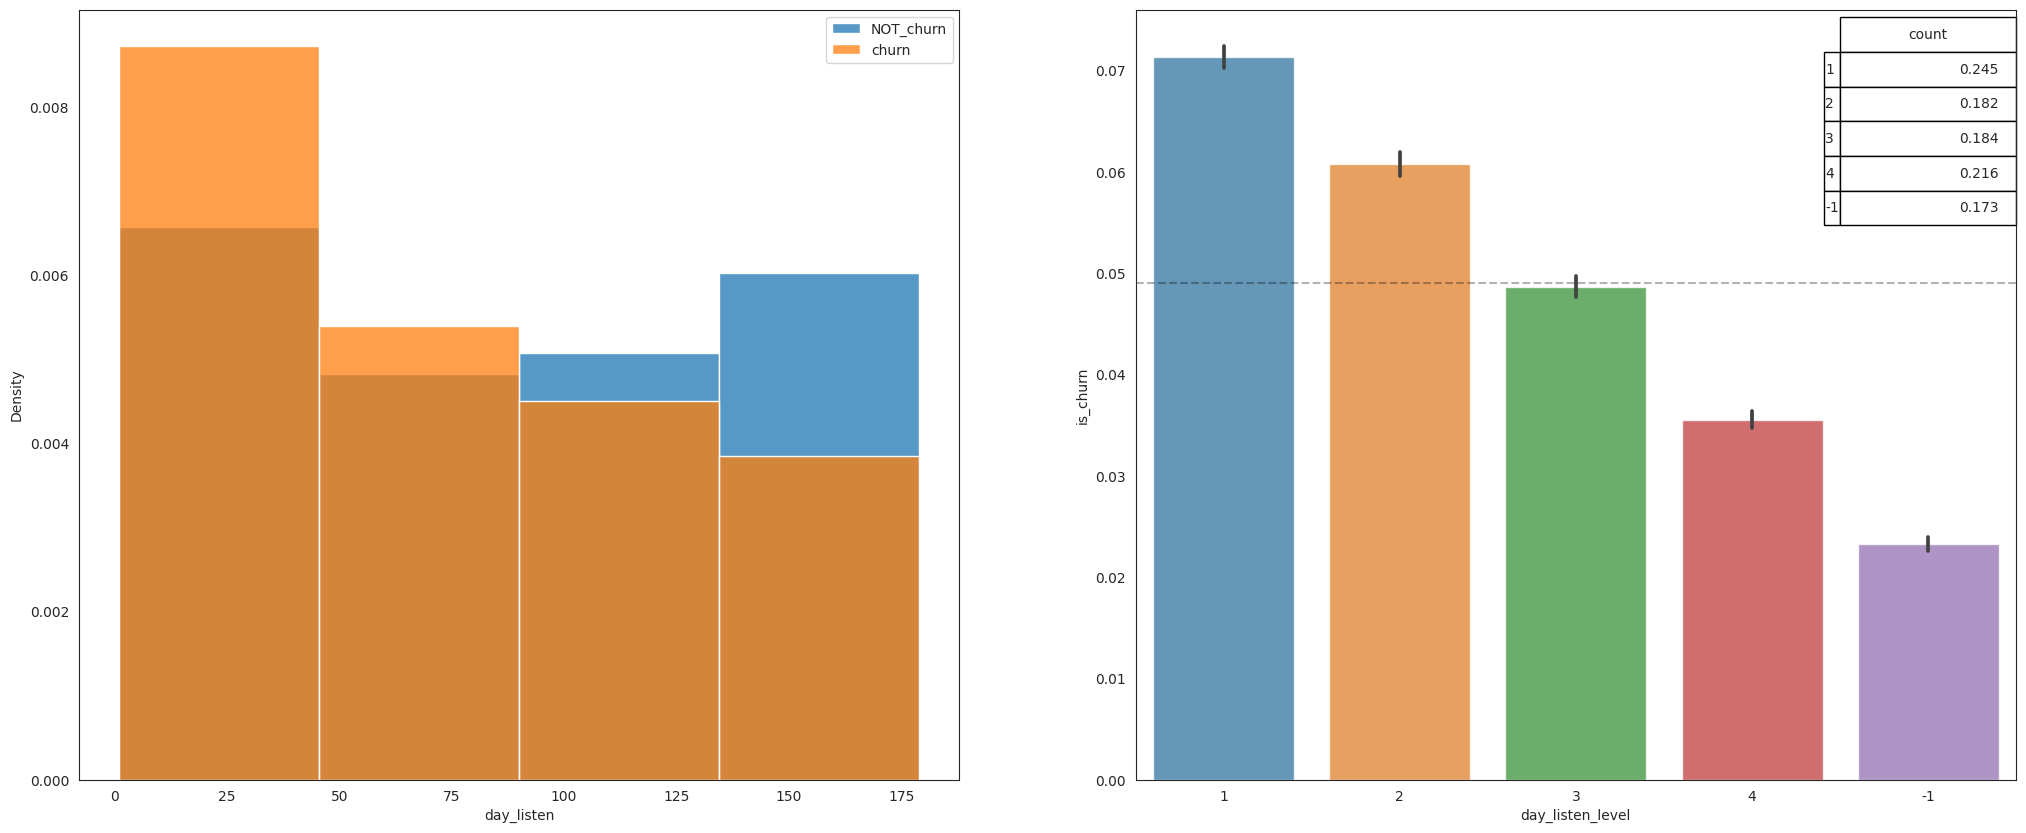

In [49]:
# distribution

with sns.axes_style('white'):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(25, 10))
    sns.histplot(df_data.loc[(df_data.is_churn == 0) & (df_data.day_listen >= 0), 'day_listen'], kde=False, bins=bins, label='NOT_churn', ax=ax1, stat='density', common_norm=False)
    sns.histplot(df_data.loc[(df_data.is_churn == 1) & (df_data.day_listen >= 0), 'day_listen'], kde=False, bins=bins, label='churn', ax=ax1, stat='density', common_norm=False)
    ax1.legend()
  
# barplot with churn_rate plus df_percent table
    sns.barplot(x='day_listen_level', y='is_churn', data=df_data,ax=ax2,alpha=.75)
    ax2.axhline(0.049,linestyle='dashed',c='black',alpha=.3)
    table(ax2, df_percent,bbox=[0.80, 0.72, 0.2, 0.27])

### 特徵工程後視覺化
1. 聽歌天數(day_listen)越多，則流失的機率越低，其效應是單調性的
2. 缺失值全部分成一類，出乎意料的有著更低的流失率，在找到填補缺失值的好方法之前，將所有缺失值列為一個類別有可能可以幫助預測，需要透過驗證集來做實驗
3. 5個類別(包含缺失值)，的數量佔比最少都有17%以上，這使得流失率的準確度是可以相信的

### Model Training

In [13]:
# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb

df_train, df_sub = df_data[:len(df_train)], df_data[len(df_train):]

print(df_train.columns)
print(df_sub.columns)

Index(['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction',
       'day_listen_level'],
      dtype='object')
Index(['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction',
       'day_listen_level'],
      dtype='object')


In [14]:
def model_training_rf(training_data,testing_data):
  # splits train and validation set
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)
  # Training ~ 01:45s
  model = RandomForestClassifier(random_state=2,n_estimators=300,
                           min_samples_split=0.05,n_jobs=-1,class_weight={0 :0.45,1 :0.55})
  model.fit(X_train,Y_train)
  
  # caculating E_val

  model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
  model_val_score = log_loss(Y_val,model_probs[:,1])
  
  # predict on testing set
  model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
  model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
  return model, model_val_score, submission

In [15]:
# 分組
day_lis_bins = ['msno','day_listen_level','is_churn']
day_listen_bins_model, day_listen_bins_val_score,\
day_listen_bins_pred = model_training_rf(df_train[day_lis_bins],df_sub[day_lis_bins])
print(day_listen_bins_val_score)

0.19426354736434337


In [54]:
day_listen_bins_pred.to_csv("gs://edward1325811540-bucket1/tsample_submission_v2.csv", index=False)

In [16]:
# user_satis
user_satis = ['msno', 'user_latent_satisfaction', 'is_churn']
user_satis_model, user_satis_val_score,\
user_satis_pred = model_training_rf(df_train[user_satis],df_sub[user_satis])
print(user_satis_val_score)

0.19558791037589174


In [ ]:
# 沒分組
df_train['day_listen'] = df_train['day_listen'].fillna(-1)
df_sub['day_listen'] = df_sub['day_listen'].fillna(-1)
day_listen = ['msno', 'day_listen', 'is_churn']
day_listen_model, day_listen_val_score,\
day_listen_pred = model_training_rf(df_train[day_listen],df_sub[day_listen])
print(day_listen_val_score)

/tmp/ipykernel_368/1907626252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['day_listen'] = df_train['day_listen'].fillna(-1)
/tmp/ipykernel_368/1907626252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['day_listen'] = df_sub['day_listen'].fillna(-1)


In [20]:
# 沒分組 user_satis
day_listen_user_satis = ['msno', 'day_listen', 'user_latent_satisfaction',  'is_churn']
day_listen_user_satis_model, day_listen_user_satis_val_score,\
day_listen_user_satis_pred = model_training_rf(df_train[day_listen_user_satis],df_sub[day_listen_user_satis])
print(day_listen_user_satis_val_score)

0.19377860331321092
